# Projeto de Engenharia do Conhecimento 2023/2024

*Projeto by: Renato Ferreira (58238), Pedro Lopes(58196), Simão Quintas (58190)*

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, matthews_corrcoef, make_scorer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler

Let's drop the rows and columns with a large number of NA values

In [2]:
data = pd.read_csv('proj-data.csv', na_values='?')

# Remover as colunas que indicam se algo foi medido ou não, a coluna com a indentificação e colunas com muitos valores ausentes
data.drop(data.filter(like='measured').columns, axis=1, inplace=True)
data.drop('[record identification]', axis=1, inplace=True)
data.drop('referral source:',axis=1,inplace=True)

hyperthyroid_conditions = ['A', 'B', 'C', 'D']
hypothyroid_conditions = ['E', 'F', 'G', 'H']
binding_protein = ['I', 'J']
general_health = ['K']
replacement_therapy = ['L', 'M', 'N']
discordant = ['R']
none = ['-']

for i in range(len(data)):
    if data.at[i, "diagnoses"] in hyperthyroid_conditions :
        data.at[i, "diagnoses"] = 1
    elif data.at[i, "diagnoses"] in hypothyroid_conditions :
        data.at[i, "diagnoses"] = 2
    elif data.at[i, "diagnoses"] in binding_protein :
        data.at[i, "diagnoses"] = 3
    elif data.at[i, "diagnoses"] in general_health :
        data.at[i, "diagnoses"] = 4
    elif data.at[i, "diagnoses"] in replacement_therapy :
        data.at[i, "diagnoses"] = 5
    elif data.at[i, "diagnoses"] in discordant :
        data.at[i, "diagnoses"] = 6
    elif data.at[i, "diagnoses"] in none :
        data.at[i, "diagnoses"] = 7 
    else:
        data.at[i, "diagnoses"] = 8 

data.replace('f', 0, inplace=True)
data.replace('t', 1, inplace=True)
data.replace('F', 0, inplace=True)
data.replace('M', 1, inplace=True)

data

C:\Users\Duarte\AppData\Local\Temp\ipykernel_18572\2595609346.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace('f', 0, inplace=True)
C:\Users\Duarte\AppData\Local\Temp\ipykernel_18572\2595609346.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace('t', 1, inplace=True)
C:\Users\Duarte\AppData\Local\Temp\ipykernel_18572\2595609346.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objec

,age:,sex:,on thyroxine:,query on thyroxine:,on antithyroid medication:,sick:,pregnant:,thyroid surgery:,I131 treatment:,query hypothyroid:,...,tumor:,hypopituitary:,psych:,TSH:,T3:,TT4:,T4U:,FTI:,TBG:,diagnoses
0,29,0.0,0,0,0,0,0,0,0,1,...,0,0,0,0.3,NaN,NaN,NaN,NaN,NaN,7
1,29,0.0,0,0,0,0,0,0,0,0,...,0,0,0,1.6,1.9,128.0,NaN,NaN,NaN,7
2,36,0.0,0,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,26.0,7
3,60,0.0,0,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,26.0,7
4,77,0.0,0,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,21.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7333,56,1.0,0,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,64.0,0.83,77.0,NaN,7
7334,22,1.0,0,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,91.0,0.92,99.0,NaN,7
7335,69,1.0,0,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,113.0,1.27,89.0,NaN,3
7336,47,0.0,0,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,75.0,0.85,88.0,NaN,7


Obter os valores da feature matrix tratados e da target variable, removendo as colunas com poucos valores.

In [3]:
missingValues = {}

for i in data.values:
  c=0
  for j in i:
    if pd.isna(j):
      if data.columns[c] not in missingValues:
        missingValues[data.columns[c]] = 1
      else:
        missingValues[data.columns[c]] += 1
    c+=1

for c in missingValues.keys():
  if missingValues[c] > 0:
    print(c,str(missingValues[c]),"missing values!")

X = data.iloc[:,:-1]

y = data.iloc[: , -1:]
y = y.astype('int')

T3: 2068 missing values!
TT4: 362 missing values!
T4U: 664 missing values!
FTI: 658 missing values!
TBG: 7054 missing values!
TSH: 671 missing values!
sex: 240 missing values!


Vamos avaliar a importância de T3 e de TBG, de forma a avaliar se os removemos ou não.

## Feature Selection

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=0)

#SCALER
scaler = StandardScaler()
scaler.fit(X_train)
Xt_train=scaler.fit_transform(X_train)
Xt_test=scaler.fit_transform(X_test)

#FEATURE SELECTION
N,M = Xt_train.shape

rfr=RandomForestRegressor(random_state=0)
sel = SelectFromModel(estimator=rfr,threshold=0.02)
y_train = y_train.squeeze().ravel()
y_test = y_test.squeeze().ravel()
sel.fit(Xt_train, y_train)

print("Default threshold: ", sel.threshold_)

features=sel.get_support()
Features_selected =np.arange(M)[features]

print("The features selected are columns: ", Features_selected)

nX_train=sel.transform(Xt_train)
nX_test=sel.transform(Xt_test)

score = make_scorer(matthews_corrcoef)

C:\Users\Duarte\AppData\Local\Temp\ipykernel_18572\531274146.py:14: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train = y_train.squeeze().ravel()
C:\Users\Duarte\AppData\Local\Temp\ipykernel_18572\531274146.py:15: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test = y_test.squeeze().ravel()


Default threshold:  0.02
The features selected are columns:  [ 0  2 16 17 18 19 20]


Feature Importances:
1: Feature 16 (0.250426 ± 0.026300)
2: Feature 17 (0.206940 ± 0.017388)
3: Feature 20 (0.157002 ± 0.037148)
4: Feature 18 (0.124443 ± 0.032979)
5: Feature 19 (0.086670 ± 0.016350)
6: Feature 2 (0.047185 ± 0.014529)
7: Feature 0 (0.045155 ± 0.009019)
8: Feature 21 (0.029692 ± 0.004991)
9: Feature 1 (0.010156 ± 0.003311)
10: Feature 6 (0.007417 ± 0.006694)
11: Feature 10 (0.006213 ± 0.002888)
12: Feature 7 (0.005990 ± 0.002525)
13: Feature 9 (0.004429 ± 0.001813)
14: Feature 4 (0.003480 ± 0.002025)
15: Feature 8 (0.002949 ± 0.001385)
16: Feature 13 (0.002935 ± 0.001583)
17: Feature 3 (0.002442 ± 0.001384)
18: Feature 15 (0.002380 ± 0.001518)
19: Feature 5 (0.002171 ± 0.001363)
20: Feature 12 (0.001047 ± 0.001060)
21: Feature 11 (0.000498 ± 0.000573)
22: Feature 14 (0.000380 ± 0.000587)


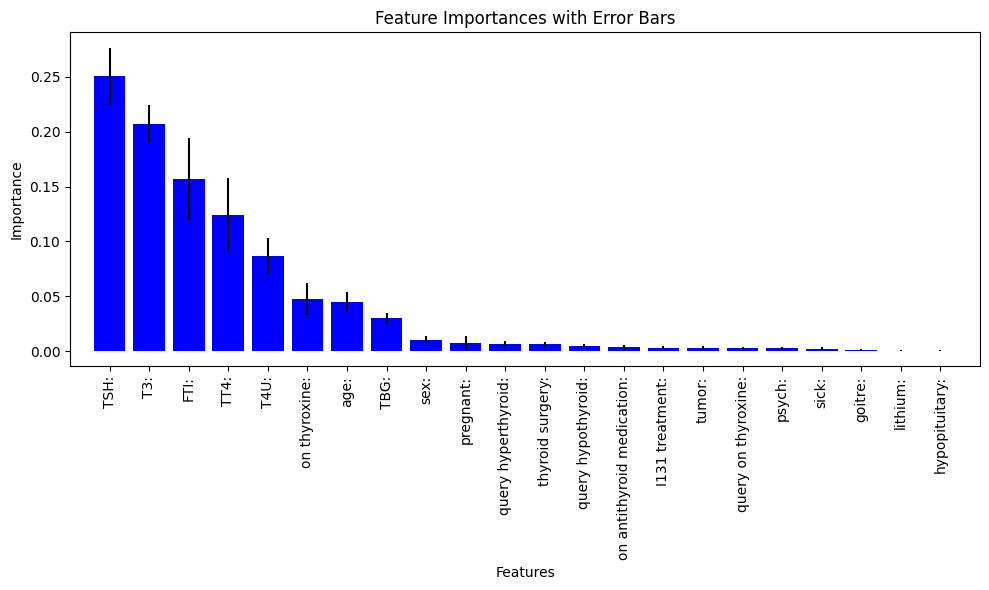

In [5]:
rfc = RandomForestClassifier(random_state=123)      
rfc.fit(Xt_train, y_train)

# Calculate feature importances and standard deviations
importances = rfc.feature_importances_
std = np.std([t.feature_importances_ for t in rfc.estimators_], axis=0)

# Sort features based on importances
indices = np.argsort(importances)[::-1]

# Print and plot feature importances with error bars
print("Feature Importances:")
for f in range(Xt_train.shape[1]):
    print("%d: Feature %d (%f ± %f)" % (f + 1, indices[f], importances[indices[f]], std[indices[f]]))
    
plt.figure(figsize=(10, 6))
plt.bar(range(Xt_train.shape[1]), importances[indices], color="b", yerr=std[indices], align="center")
plt.xticks(range(Xt_train.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, Xt_train.shape[1]])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances with Error Bars")
plt.tight_layout()
plt.show()

# Métodos

In [6]:
def present_statistics(y_test, preds):
    print("Statistics:")
    print("The Precision is: %7.4f" % precision_score(y_test, preds, average='weighted'))
    print("The Accuracy is: %7.4f" % accuracy_score(y_test, preds))
    print("The Recall is: %7.4f" % recall_score(y_test, preds, average='weighted'))
    print("The F1 score is: %7.4f" % f1_score(y_test, preds, average='weighted'))
    print("The Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(y_test, preds))
    print("-------------------------------------------------------------")

## Decision Tree

### Testar o modelo Decision Tree Classifier

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

print("Com valores Nan, sem scaler:")

# Create and train the DecisionTreeClassifier model
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

# Make predictions
tree_preds = tree_model.predict(X_test)
present_statistics(y_test, tree_preds)

print("Sem valores Nan, sem scaler:")

# Create an instance of the SimpleImputer class with fill_value='-1'
imputer = SimpleImputer(strategy='constant', fill_value=-1)

# Replace missing values with -1 in the training and testing data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Train the DecisionTreeClassifier model with the simple imputer
tree_model.fit(X_train_imputed, y_train)

# Make predictions
tree_preds = tree_model.predict(X_test_imputed)
present_statistics(y_test, tree_preds)

print("Com valores Nan, com scaler:")

# Train the DecisionTreeClassifier model with the simple imputer
tree_model.fit(Xt_train, y_train)

# Make predictions
tree_preds = tree_model.predict(Xt_test)
present_statistics(y_test, tree_preds)

print("Sem valores Nan, com scaler:")

X_train_imputed = imputer.fit_transform(Xt_train)
X_test_imputed = imputer.transform(Xt_test)

tree_model.fit(X_train_imputed, y_train)

tree_preds = tree_model.predict(X_test_imputed)
present_statistics(y_test, tree_preds)

Com valores Nan, sem scaler:
Statistics:
The Precision is:  0.9336
The Accuracy is:  0.9341
The Recall is:  0.9341
The F1 score is:  0.9337
The Matthews correlation coefficient is:  0.8546
-------------------------------------------------------------
Sem valores Nan, sem scaler:
Statistics:
The Precision is:  0.9354
The Accuracy is:  0.9357
The Recall is:  0.9357
The F1 score is:  0.9355
The Matthews correlation coefficient is:  0.8586
-------------------------------------------------------------
Com valores Nan, com scaler:
Statistics:
The Precision is:  0.9093
The Accuracy is:  0.9084
The Recall is:  0.9084
The F1 score is:  0.9076
The Matthews correlation coefficient is:  0.7968
-------------------------------------------------------------
Sem valores Nan, com scaler:
Statistics:
The Precision is:  0.8986
The Accuracy is:  0.8992
The Recall is:  0.8992
The F1 score is:  0.8955
The Matthews correlation coefficient is:  0.7716
----------------------------------------------------------

Os resultados ao utilizar valores Nan são melhores.

In [8]:
y_train_flat = np.ravel(y_train)
y_test_flat = np.ravel(y_test)

## KNeighbors

In [9]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)

print("Usando um scaler:")

# Replace missing values with -1 in the scaled training and testing data
X_train_imputed = imputer.fit_transform(Xt_train)
X_test_imputed = imputer.transform(Xt_test)

knn_model.fit(X_train_imputed, y_train_flat)

# Predictions
knn_preds = knn_model.predict(X_test_imputed)
present_statistics(y_test, knn_preds)

print("Sem usar scaler:")

# Replace missing values with -1 in the training and testing data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

knn_model.fit(X_train_imputed, y_train_flat)

# Predictions
knn_preds = knn_model.predict(X_test_imputed)
present_statistics(y_test_flat, knn_preds)

Usando um scaler:
Statistics:
The Precision is:  0.8165
The Accuracy is:  0.8289
The Recall is:  0.8289
The F1 score is:  0.8148
The Matthews correlation coefficient is:  0.5858
-------------------------------------------------------------
Sem usar scaler:
Statistics:
The Precision is:  0.7695
The Accuracy is:  0.7913
The Recall is:  0.7913
The F1 score is:  0.7757
The Matthews correlation coefficient is:  0.5035
-------------------------------------------------------------


É melhor ao usar um scaler

## SVC

In [10]:
from sklearn.svm import SVC
svc_model = SVC()

print(svc_model,"usando scaler:")
# Replace missing values with -1 in the training and testing data
X_train_imputed = imputer.fit_transform(Xt_train)
X_test_imputed = imputer.transform(Xt_test)

svc_model.fit(X_train_imputed, y_train_flat)

svc_preds = svc_model.predict(X_test_imputed)
present_statistics(y_test_flat, svc_preds)

print(svc_model,"sem scaler:")

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

svc_model.fit(X_train_imputed, y_train_flat)

svc_preds = svc_model.predict(X_test_imputed)
present_statistics(y_test_flat, svc_preds)

SVC() usando scaler:
Statistics:
The Precision is:  0.8033
The Accuracy is:  0.8120
The Recall is:  0.8120
The F1 score is:  0.7741
The Matthews correlation coefficient is:  0.5171
-------------------------------------------------------------
SVC() sem scaler:
Statistics:
The Precision is:  0.6047
The Accuracy is:  0.7362
The Recall is:  0.7362
The F1 score is:  0.6319
The Matthews correlation coefficient is:  0.1457
-------------------------------------------------------------


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gaus_model = GaussianNB()

print(gaus_model,"sem scaler:")

# Replace missing values with -1 in the training and testing data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

gaus_model.fit(X_train_imputed, y_train_flat)

gaus_preds = gaus_model.predict(X_test_imputed)
present_statistics(y_test_flat, gaus_preds)

print(gaus_model,"com scaler:")

X_train_imputed = imputer.fit_transform(Xt_train)
X_test_imputed = imputer.transform(Xt_test)

gaus_model.fit(X_train_imputed, y_train_flat)

gaus_preds = gaus_model.predict(X_test_imputed)
present_statistics(y_test_flat, gaus_preds)

## LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
logr_model = LogisticRegression(max_iter=1000)

print(logr_model,"com scaler:")

# Replace missing values with -1 in the training and testing data
X_train_imputed = imputer.fit_transform(Xt_train)
X_test_imputed = imputer.transform(Xt_test)

# Train models
logr_model.fit(X_train_imputed, y_train_flat)

logr_preds = logr_model.predict(X_test_imputed)
present_statistics(y_test_flat, logr_preds)

print(logr_model,"sem scaler:")

# Replace missing values with -1 in the training and testing data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Train models
logr_model.fit(X_train_imputed, y_train_flat)

logr_preds = logr_model.predict(X_test_imputed)
present_statistics(y_test_flat, logr_preds)

Os melhores modelos são o Decision Tree, KNeighbors e LogisticRegression

## Model Tuning

### Decision Tree Classifier

In [ ]:
param_grid = {
    'max_depth': [None,*range(3, 30)],
    'min_samples_split': [*range(2,15)],
    'min_samples_leaf': [*range(2,15)],
    'max_features': [None],
    'criterion': ['gini','entropy']
}

tree_model = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='f1_macro')

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_tree_model = grid_search.best_estimator_

tree_preds = best_tree_model.predict(X_test)

present_statistics(y_test, tree_preds)

# Perform cross-validation with the best estimator
cv_scores = cross_val_score(best_tree_model, X_train, y_train, cv=5, scoring='f1_macro')

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())
print("Standard Deviation of Cross-Validation Score:", cv_scores.std())

### KNeighbours

In [ ]:
param_grid = {
    'n_neighbors': [3,5,7,9,11,13,15,17],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

knn_model = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, scoring='f1_weighted')

X_train_imputed = imputer.fit_transform(Xt_train)
X_test_imputed = imputer.transform(Xt_test)

grid_search.fit(X_train_imputed, y_train_flat)

print("Best Parameters:", grid_search.best_params_)

best_knn_model = grid_search.best_estimator_

knn_preds = best_knn_model.predict(X_test_imputed)

present_statistics(y_test_flat, knn_preds)

# Perform cross-validation with the best estimator
cv_scores = cross_val_score(best_knn_model, X_train_imputed, y_train_flat, cv=5, scoring='f1_macro')

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())
print("Standard Deviation of Cross-Validation Score:", cv_scores.std())

### Logistic Regression

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear']
}

logreg_model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed

grid_search = GridSearchCV(estimator=logreg_model, param_grid=param_grid, cv=5, scoring='f1_weighted')

X_train_imputed = imputer.fit_transform(Xt_train)
X_test_imputed = imputer.transform(Xt_test)

grid_search.fit(X_train_imputed, y_train_flat)

print("Best Parameters:", grid_search.best_params_)

best_logreg_model = grid_search.best_estimator_

logreg_preds = best_logreg_model.predict(X_test_imputed)

present_statistics(y_test_flat, logreg_preds)

# Perform cross-validation with the best estimator
cv_scores = cross_val_score(best_logreg_model, X_train_imputed, y_train_flat, cv=5, scoring='f1_macro')

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())
print("Standard Deviation of Cross-Validation Score:", cv_scores.std())

Escolhemos o Decision Tree com os parâmetros:
'criterion': 'gini', 
'max_depth': 17, 
'max_features': None, 
'min_samples_leaf': 3, 
'min_samples_split': 10, por ter sido aquele com melhor cross-validation score e com menor standard deviation

# O2

## Idade

In [12]:
from sklearn.metrics import r2_score
#OBJETIVO 2 : IDADE

data_age = pd.read_csv('proj-data.csv', na_values='?')

data_age.drop(data_age.filter(like='measured').columns, axis=1, inplace=True)
data_age.drop('[record identification]', axis=1, inplace=True)
data_age.drop('referral source:',axis=1,inplace=True)
data_age.dropna(subset=['age:'],inplace=True)

for i in range(len(data_age)):
    if data_age.at[i, "diagnoses"] in hyperthyroid_conditions :
        data_age.at[i, "diagnoses"] = 1
    elif data_age.at[i, "diagnoses"] in hypothyroid_conditions :
        data_age.at[i, "diagnoses"] = 2
    elif data_age.at[i, "diagnoses"] in binding_protein :
        data_age.at[i, "diagnoses"] = 3
    elif data_age.at[i, "diagnoses"] in general_health :
        data_age.at[i, "diagnoses"] = 4
    elif data_age.at[i, "diagnoses"] in replacement_therapy :
        data_age.at[i, "diagnoses"] = 5
    elif data_age.at[i, "diagnoses"] in discordant :
        data_age.at[i, "diagnoses"] = 6
    elif data_age.at[i, "diagnoses"] in none :
        data_age.at[i, "diagnoses"] = 7
    else:
        data_age.at[i, "diagnoses"] = 8 

data_age.replace('f', 0, inplace=True)
data_age.replace('t', 1, inplace=True)
data_age.replace('F', 0, inplace=True)
data_age.replace('M', 1, inplace=True)

X_age = data_age.iloc[:,1:]
y_age = data_age.iloc[: , :1]

X_train, X_test, y_train, y_test = train_test_split(X_age, y_age, test_size=0.25,random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
Xt_train=scaler.fit_transform(X_train)
Xt_test=scaler.fit_transform(X_test)

C:\Users\Duarte\AppData\Local\Temp\ipykernel_18572\1097036757.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_age.replace('f', 0, inplace=True)
C:\Users\Duarte\AppData\Local\Temp\ipykernel_18572\1097036757.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_age.replace('t', 1, inplace=True)
C:\Users\Duarte\AppData\Local\Temp\ipykernel_18572\1097036757.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.inf

### SVR

In [13]:
from sklearn.svm import SVR
model = SVR()

print("02AGE SVR sem valores Nan, com scaler:")

X_train_imputed = imputer.fit_transform(Xt_train)
X_test_imputed = imputer.transform(Xt_test)

model.fit(X_train_imputed, y_train)

preds = model.predict(X_test_imputed)
print("R2 Score:",r2_score(y_test, preds))

y_train_flat = np.ravel(y_train)
y_test_flat = np.ravel(y_test)

02AGE SVR sem valores Nan, com scaler:


c:\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2 Score: 0.10640629561458137


## Best Features

c:\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Feature Importances:
1: Feature 15 (0.346583 ± 0.360571)
2: Feature 16 (0.240300 ± 0.280286)
3: Feature 17 (0.123893 ± 0.189699)
4: Feature 0 (0.117896 ± 0.216937)
5: Feature 18 (0.070048 ± 0.127782)
6: Feature 19 (0.055082 ± 0.137560)
7: Feature 21 (0.022469 ± 0.116142)
8: Feature 2 (0.005342 ± 0.049754)
9: Feature 12 (0.004282 ± 0.033173)
10: Feature 9 (0.003739 ± 0.003794)
11: Feature 20 (0.001846 ± 0.005055)
12: Feature 1 (0.001790 ± 0.004928)
13: Feature 8 (0.001426 ± 0.003969)
14: Feature 14 (0.001227 ± 0.003386)
15: Feature 4 (0.001205 ± 0.003320)
16: Feature 7 (0.000735 ± 0.002117)
17: Feature 6 (0.000564 ± 0.001602)
18: Feature 3 (0.000532 ± 0.001499)
19: Feature 5 (0.000379 ± 0.001151)
20: Feature 11 (0.000354 ± 0.001080)
21: Feature 10 (0.000262 ± 0.000792)
22: Feature 13 (0.000046 ± 0.000274)


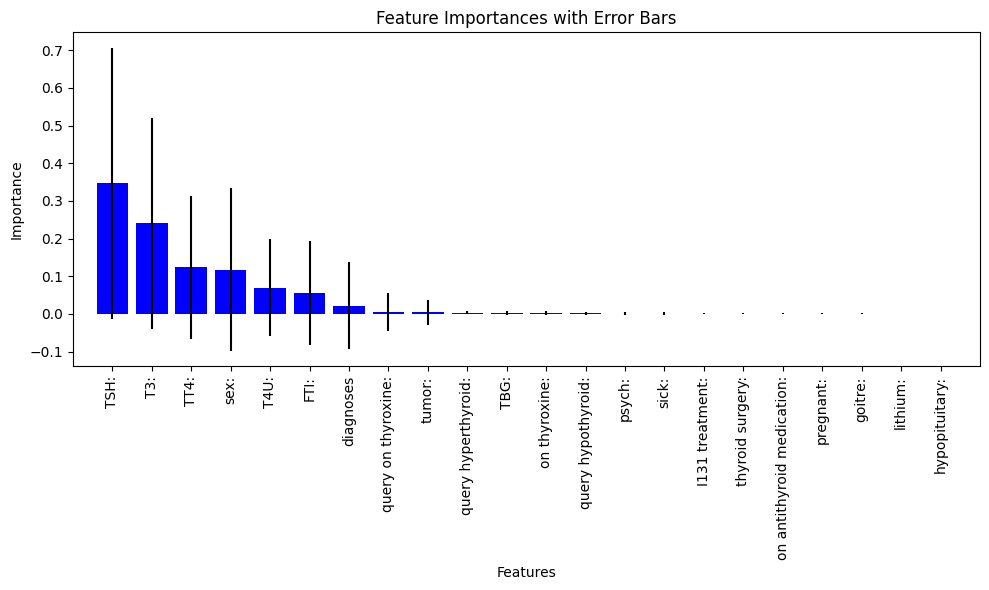

In [14]:
rfr.fit(X_train_imputed, y_train)

# Calculate feature importances and standard deviations
importances = rfr.feature_importances_
std = np.std([t.feature_importances_ for t in rfr.estimators_], axis=0)

# Sort features based on importances
indices = np.argsort(importances)[::-1]

# Print and plot feature importances with error bars
print("Feature Importances:")
for f in range(X_train_imputed.shape[1]):
    print("%d: Feature %d (%f ± %f)" % (f + 1, indices[f], importances[indices[f]], std[indices[f]]))
    
plt.figure(figsize=(10, 6))
plt.bar(range(X_train_imputed.shape[1]), importances[indices], color="b", yerr=std[indices], align="center")
plt.xticks(range(X_train_imputed.shape[1]), X_age.columns[indices], rotation=90)
plt.xlim([-1, X_train_imputed.shape[1]])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances with Error Bars")
plt.tight_layout()
plt.show()

## Sexo

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# OBJETIVO 2: SEX

data_sex = pd.read_csv('proj-data.csv', na_values='?')

data_sex.drop(data_sex.filter(like='measured').columns, axis=1, inplace=True)
data_sex.drop('[record identification]', axis=1, inplace=True)
data_sex.drop('referral source:', axis=1, inplace=True)
data_sex.dropna(subset=['sex:'], inplace=True)

# Reset index after dropping rows with NaN values
data_sex.reset_index(drop=True, inplace=True)

for i in range(len(data_sex)):
    if data_sex.at[i, "diagnoses"] in hyperthyroid_conditions:
        data_sex.at[i, "diagnoses"] = 1
    elif data_sex.at[i, "diagnoses"] in hypothyroid_conditions:
        data_sex.at[i, "diagnoses"] = 2
    elif data_sex.at[i, "diagnoses"] in binding_protein:
        data_sex.at[i, "diagnoses"] = 3
    elif data_sex.at[i, "diagnoses"] in general_health:
        data_sex.at[i, "diagnoses"] = 4
    elif data_sex.at[i, "diagnoses"] in replacement_therapy:
        data_sex.at[i, "diagnoses"] = 5
    elif data_sex.at[i, "diagnoses"] in discordant:
        data_sex.at[i, "diagnoses"] = 6
    elif data_sex.at[i, "diagnoses"] in none:
        data_sex.at[i, "diagnoses"] = 7
    else:
        data_sex.at[i, "diagnoses"] = 8

data_sex.replace('f', 0, inplace=True)
data_sex.replace('t', 1, inplace=True)
data_sex.replace('F', 0, inplace=True)
data_sex.replace('M', 1, inplace=True)

X_sex = data_sex.iloc[:, :]
X_sex.drop('sex:', axis=1, inplace=True)

y_sex = data_sex[['sex:']]  # Extract 'sex:' column for y_sex

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sex, y_sex, test_size=0.25, random_state=0)

# Ensure y_train and y_test are in the correct shape for fitting the model
y_train_flat = y_train.values.ravel()
y_test_flat = y_test.values.ravel()

C:\Users\Duarte\AppData\Local\Temp\ipykernel_18572\2431532685.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_sex.replace('f', 0, inplace=True)
C:\Users\Duarte\AppData\Local\Temp\ipykernel_18572\2431532685.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_sex.replace('t', 1, inplace=True)
C:\Users\Duarte\AppData\Local\Temp\ipykernel_18572\2431532685.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.inf

### KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize imputer
imputer = SimpleImputer(strategy='mean')

# Standardize the features
scaler = StandardScaler()

# Impute and scale the data
print("02SEX KNN tree usando um scaler:")

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.transform(X_test_scaled)

knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train_imputed, y_train_flat)

knn_preds = knn_model.predict(X_test_imputed)
present_statistics(y_test_flat, knn_preds)

02SEX KNN tree usando um scaler:
Statistics:
The Precision is:  0.6613
The Accuracy is:  0.6851
The Recall is:  0.6851
The F1 score is:  0.6655
The Matthews correlation coefficient is:  0.2098
-------------------------------------------------------------


## Best Features

Feature Importances:
1: Feature 0 (0.164997 ± 0.012596)
2: Feature 18 (0.160484 ± 0.015184)
3: Feature 17 (0.149024 ± 0.014450)
4: Feature 15 (0.147808 ± 0.011422)
5: Feature 19 (0.138332 ± 0.010890)
6: Feature 16 (0.113107 ± 0.010550)
7: Feature 21 (0.025594 ± 0.005088)
8: Feature 1 (0.013519 ± 0.003267)
9: Feature 20 (0.012414 ± 0.002881)
10: Feature 14 (0.012058 ± 0.003587)
11: Feature 9 (0.010842 ± 0.002909)
12: Feature 8 (0.010639 ± 0.002574)
13: Feature 4 (0.007979 ± 0.002342)
14: Feature 12 (0.006390 ± 0.001803)
15: Feature 2 (0.005896 ± 0.002388)
16: Feature 7 (0.004938 ± 0.001797)
17: Feature 10 (0.003854 ± 0.001337)
18: Feature 3 (0.003743 ± 0.001584)
19: Feature 11 (0.003465 ± 0.001534)
20: Feature 6 (0.003385 ± 0.001391)
21: Feature 5 (0.001365 ± 0.001605)
22: Feature 13 (0.000165 ± 0.000401)


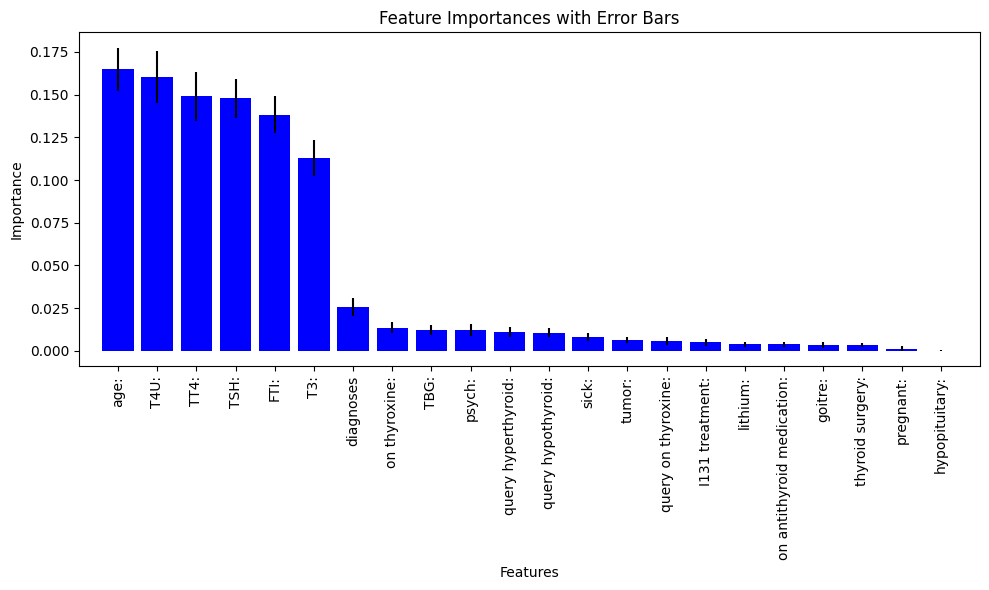

In [17]:
rfc = RandomForestClassifier(random_state=123)      
rfc.fit(X_train_imputed, y_train_flat)

# Calculate feature importances and standard deviations
importances = rfc.feature_importances_
std = np.std([t.feature_importances_ for t in rfc.estimators_], axis=0)

# Sort features based on importances
indices = np.argsort(importances)[::-1]

# Print and plot feature importances with error bars
print("Feature Importances:")
for f in range(X_train_imputed.shape[1]):
    print("%d: Feature %d (%f ± %f)" % (f + 1, indices[f], importances[indices[f]], std[indices[f]]))
    
plt.figure(figsize=(10, 6))
plt.bar(range(X_train_imputed.shape[1]), importances[indices], color="b", yerr=std[indices], align="center")
plt.xticks(range(X_train_imputed.shape[1]), X_sex.columns[indices], rotation=90)
plt.xlim([-1, X_train_imputed.shape[1]])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances with Error Bars")
plt.tight_layout()
plt.show()

# Célula final

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

data = pd.read_csv('proj-data.csv', na_values='?')
testData = pd.read_csv('proj-test-data.csv', na_values='?')
testClass = pd.read_csv('proj-test-class.csv', na_values='?')

data.drop(data.filter(like='measured').columns, axis=1, inplace=True)
data.drop('[record identification]', axis=1, inplace=True)
data.drop('referral source:',axis=1,inplace=True)

hyperthyroid_conditions = ['A', 'B', 'C', 'D']
hypothyroid_conditions = ['E', 'F', 'G', 'H']
binding_protein = ['I', 'J']
general_health = ['K']
replacement_therapy = ['L', 'M', 'N']
discordant = ['R']
none = ['-']

for i in range(len(data)):
    if data.at[i, "diagnoses"] in hyperthyroid_conditions :
        data.at[i, "diagnoses"] = 1
    elif data.at[i, "diagnoses"] in hypothyroid_conditions :
        data.at[i, "diagnoses"] = 2
    elif data.at[i, "diagnoses"] in binding_protein :
        data.at[i, "diagnoses"] = 3
    elif data.at[i, "diagnoses"] in general_health :
        data.at[i, "diagnoses"] = 4
    elif data.at[i, "diagnoses"] in replacement_therapy :
        data.at[i, "diagnoses"] = 5
    elif data.at[i, "diagnoses"] in discordant :
        data.at[i, "diagnoses"] = 6
    elif data.at[i, "diagnoses"] in none :
        data.at[i, "diagnoses"] = 7 
    else:
        data.at[i, "diagnoses"] = 8 

for i in range(len(testClass)):
    if testClass.at[i, "diagnoses"] in hyperthyroid_conditions :
        testClass.at[i, "diagnoses"] = 1
    elif testClass.at[i, "diagnoses"] in hypothyroid_conditions :
        testClass.at[i, "diagnoses"] = 2
    elif testClass.at[i, "diagnoses"] in binding_protein :
        testClass.at[i, "diagnoses"] = 3
    elif testClass.at[i, "diagnoses"] in general_health :
        testClass.at[i, "diagnoses"] = 4
    elif testClass.at[i, "diagnoses"] in replacement_therapy :
        testClass.at[i, "diagnoses"] = 5
    elif testClass.at[i, "diagnoses"] in discordant :
        testClass.at[i, "diagnoses"] = 6
    elif testClass.at[i, "diagnoses"] in none :
        testClass.at[i, "diagnoses"] = 7 
    else:
        testClass.at[i, "diagnoses"] = 8 

data.replace('f', 0, inplace=True)
data.replace('t', 1, inplace=True)
data.replace('F', 0, inplace=True)
data.replace('M', 1, inplace=True)

X = data.iloc[:,:-1]

y = data.iloc[: , -1:]
y = y.astype('int')


X = data.iloc[:,:-1]

y = data.iloc[: , -1:]
y = y.astype('int')

tree_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 27, max_features = None, min_samples_leaf = 2, min_samples_split = 6)
tree_model.fit(X, y)

testData.drop(testData.filter(like='measured').columns, axis=1, inplace=True)
testData.drop('[record identification]', axis=1, inplace=True)
testData.drop('referral source:',axis=1,inplace=True)

testData.replace('f', 0, inplace=True)
testData.replace('t', 1, inplace=True)
testData.replace('F', 0, inplace=True)
testData.replace('M', 1, inplace=True)

# Make predictions
tree_preds = tree_model.predict(testData)
testClass_flat = testClass['diagnoses'].astype(int).values.flatten()
print("Valores do teste:")
print(testClass_flat)
print("Valores da previsão:")
print(tree_preds)
present_statistics(testClass_flat, tree_preds)
